In [92]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt #for making figures
%matplotlib inline

In [93]:
words = open("names.txt", "r").read().splitlines()
#String to integer and integer to string mappings have been created
chars = sorted(list(set( "".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [94]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [95]:
# MLP revisited
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) *0.05
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True


11897


In [101]:
# same optimization as last time
max_steps = 200001
batch_size = 32
lossi = []
stepi = []


for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    stepi.append(i)

      0/ 200001: 3.2732
  10000/ 200001: 2.2550
  20000/ 200001: 1.8299
  30000/ 200001: 2.3065
  40000/ 200001: 2.1462
  50000/ 200001: 1.9536
  60000/ 200001: 2.2145
  70000/ 200001: 2.2169
  80000/ 200001: 2.1085
  90000/ 200001: 2.0017
 100000/ 200001: 2.1838
 110000/ 200001: 2.0493
 120000/ 200001: 1.6922
 130000/ 200001: 2.0789
 140000/ 200001: 1.6084
 150000/ 200001: 1.9878
 160000/ 200001: 2.0576
 170000/ 200001: 1.9381
 180000/ 200001: 1.6651
 190000/ 200001: 2.3839
 200000/ 200001: 2.0354


# Problems, problems, problems...

### Expected loss
The initial loss of the function is over 27,8 which is all fucked up... Why? Let's assume a uniform distribution of 27 characters and calculate the loss: log(1/27) = 3,29
The problem is we initialize our values randomly from a normal distribution

Solution: Set bias to 0 and scale the Weights by a small number (0.01) to have values close to zero but not 0 to avoid 

### tanh
<img src ="tanh1.png" width = "300"> 
Our tanh puts most values to 1 or -1 and this reduces our learning rate. 
Backward pass of tanh look like (1-t^2) * out.grad -> If t is close to one our gradient is getting washed away, which makes our training very ineffective and it might even cause **braindamage** where a neuron is never activated for any example and it never learns

Solution: Scale down the Weights of the activation layer so that smaller numbers get passed to tanh

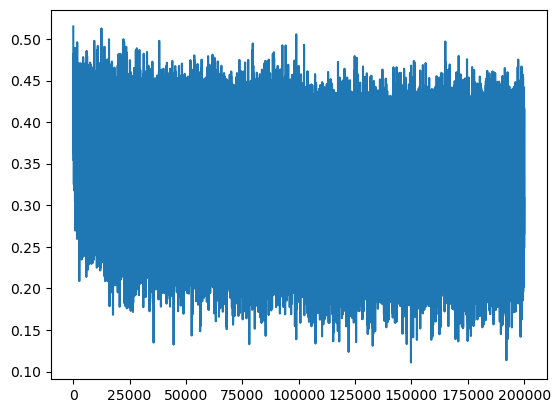

In [103]:
plt.plot(stepi, lossi)

In [99]:
@torch.no_grad() # this decorator disables gradient tracking for efficiency, as we will not run any gradient optimzation on our evaluation
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


train 3.2833497524261475
val 3.283463478088379


In [100]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out)) # decode and print the generated word


erbuagmyazzszevvndhfyaloqetvrsjejdrljg.
ozcjedgeliihsmpqppalekeixvqnwxarqeptzcmhvqrpcn.
szdbvrgxhgmjest.
jcjrwjkjqqxntpucfkubzmgvdtrxyqqufzehg.
kmejqvskkydmzhjl.
cakyybsufpzbjglvjurenjcrtvwsvevoecmpfhdxrfqyxoeobhggptixjsfcueywhkhmrjolviilqiif.
wvpkxwvlla.
ortabfsztjndgoikvsblitgfkxvbssivpu.
meewrkepxcmvyhxavttudkjgczekhgcgtipvtudt.
iwbddihzvorlq.
cjakepxugniagcrpppfmiipzjgvonxet.
jydnblkskzporygnogsvmwosfzybsyknvmjcxtkncjbmu.
jtew.
aow.
copmrlxkkdcqbcep.
ccdfivsnipimhtewmokagouwzlrurdckappomtcokwxtnbnzkdphfam.
xcojfffuncxzhosy.
sj.
ascnpc.
cilwtanczhndtebimm.
